In [1]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy
import os
import matplotlib as mpl
import matplotlib.tri as tri
import ternary
import pickle
import datetime
from collections import Counter
import matplotlib.ticker as ticker
import pyDOE
import random
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import matplotlib.font_manager as font_manager
import copy
from scipy.interpolate import splrep
from scipy.interpolate import interp1d

# Load materials dataset

In [2]:
# go to directory where datasets reside
# load a dataset
# dataset names = ['Crossed barrel', 'Perovskite', 'AgNP', 'P3HT', 'AutoAM']
dataset_name = 'Crossed barrel'
raw_dataset = pd.read_csv(dataset_name + '_dataset.csv')
feature_name = list(raw_dataset.columns)[:-1]
objective_name = list(raw_dataset.columns)[-1]

# Processing

In [3]:
ds = copy.deepcopy(raw_dataset) 
# only P3HT/CNT, Crossed barrel, AutoAM need this line; Perovskite and AgNP do not need this line.
ds[objective_name] = -raw_dataset[objective_name].values

ds_grouped = ds.groupby(feature_name)[objective_name].agg(lambda x: x.unique().mean())
ds_grouped = (ds_grouped.to_frame()).reset_index()

s_scaler = preprocessing.StandardScaler()
ds_normalized_values = s_scaler.fit_transform(ds_grouped[list(raw_dataset.columns)].values)
ds_normalized = pd.DataFrame(ds_normalized_values, columns = list(raw_dataset.columns))
ds_normalized

,n,theta,r,t,toughness
0,-1.341641,-1.53393,-1.565561,-1.224745,1.310884
1,-1.341641,-1.53393,-1.565561,0.000000,1.285839
2,-1.341641,-1.53393,-1.565561,1.224745,1.291659
3,-1.341641,-1.53393,-0.939336,-1.224745,1.129119
4,-1.341641,-1.53393,-0.939336,0.000000,1.120426
...,...,...,...,...,...
595,1.341641,1.53393,0.939336,0.000000,0.974535
596,1.341641,1.53393,0.939336,1.224745,1.231253
597,1.341641,1.53393,1.565561,-1.224745,-0.890291
598,1.341641,1.53393,1.565561,0.000000,1.290123


In [4]:
# pool size
nsteps = len(ds_grouped)
# number of top candidates, currently using top 5% of total dataset size
n_top = int(math.ceil(nsteps * 0.05))
# the top candidates and their indicies
top_indices = list(ds_grouped.sort_values(objective_name).head(n_top).index)

# Load calculation results from framework

In [5]:
# Load ensemble calculation results from framework
# for 50 ensembles, they take some time to run
# we therefore provide sample results for BO algorithm GP_ARD_Matern52_LCB1 and RF_LCB1
# the ratio between mean and std in acquisition function LCB is 1
# please retrieve the following files from vis_demo_calc folder

TopCount_collection_GP_ARD_Matern52_LCB1 = np.load('TopCount_collection_GP_ARD_Matern52_LCB1.npy', allow_pickle = True)
TopCount_collection_RF_LCB1 = np.load('TopCount_collection_RF_LCB1.npy', allow_pickle = True)

# Random baseline

In [6]:
def P_rand(nn):
    x_random = np.arange(nn)
    
    M = n_top
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    A = np.array([None for i in x_random])
    cA = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    A[0] = M / N
    cA[0] = A[0]
    

    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        j = 0
        A_i = P[i]
        while j < i:
            A_i *= (1 - P[j])
            j+=1
        A[i] = A_i
        cA[i] = np.sum(A[:(i+1)])
        
    return E / M, cA

# Aggregation of performance

In [7]:
seed_list = [5782, 5776, 9975, 4569, 8020, 363, 9656, 992, 348, 6048, 4114, 7476, 4892, 9710, 9854, 5243, 
             2906, 5963, 3035, 5122, 9758, 4327, 4921, 6179, 1718, 441, 9326, 2153, 5079, 8192, 3646, 4413, 
             3910, 5370, 3070, 7130, 1589, 1668, 9842, 5275, 5468, 3677, 7183, 2773, 1309, 5516, 3572, 9312, 
             7390, 4433, 3686, 1981, 555, 8677, 3126, 5163, 9418, 3007, 4564, 5572, 1401, 5657, 9658, 2124, 
             6902, 4783, 8493, 4442, 7613, 5674, 6830, 4757, 6877, 9311, 6709, 582, 6770, 2555, 3269, 76, 
             7820, 8358, 7116, 9156, 3638, 529, 7482, 8503, 4735, 8910, 5588, 3726, 1115, 9644, 4702, 1966, 
             4006, 738, 575, 8393]

def aggregation_(seed, n_runs, n_fold):
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    
    index_runs = list(np.arange(n_runs))
    
    agg_list = []
    
    i = 0
    
    while i < n_fold:
    
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
            
        agg_list.append(index_i)
        
        i += 1
#     print(agg_list)    
    return agg_list

def avg_(x):
#     nsteps
    n_eval = len(x[0]) 
    
#     fold
    n_fold = 5
    
#     rows = # of ensembles = 50
    n_runs = len(x)
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
#     # of seeds 
    n_sets = len(seed_list)
    
    l_index_list = []
    
    for i in np.arange(n_sets):
        
        s = aggregation_(seed_list[i], n_runs, n_fold)
        l_index_list.extend(s)

#     rows in l_index_list

    assert len(l_index_list) == n_sets * n_fold
    

    
    l_avg_runs = []

    for i in np.arange(len(l_index_list)):
        
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            
            avg_run += np.array(x[j])
            
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    

    assert n_eval == len(l_avg_runs[0])
    assert n_sets * n_fold == len(l_avg_runs)
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    

#     25th, 75th percentile, mean, median are all accessible
    for i in np.arange(len(l_avg_runs[0])):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_), np.array(low_q), np.array(high_q), np.array(mean_), np.array(std_)

# Top%

In [8]:
def TopPercent(x):
    
    n_eval = len(x[0])
    
    x_ = [[] for i in np.arange(len(x))]
    
    for j in np.arange(len(x)):
        for i in np.arange(n_eval):
            x_[j].append(x[j][i] / n_top)
        
    return x_

In [9]:
# Aggregating the performance
TopPercent_GP_ARD_Matern52_LCB1 = avg_(TopPercent(TopCount_collection_GP_ARD_Matern52_LCB1))
TopPercent_RF_LCB1 = avg_(TopPercent(TopCount_collection_RF_LCB1))

([<matplotlib.axis.YTick at 0x1a2ba4b9d0>,
 <a list of 6 Text yticklabel objects>)

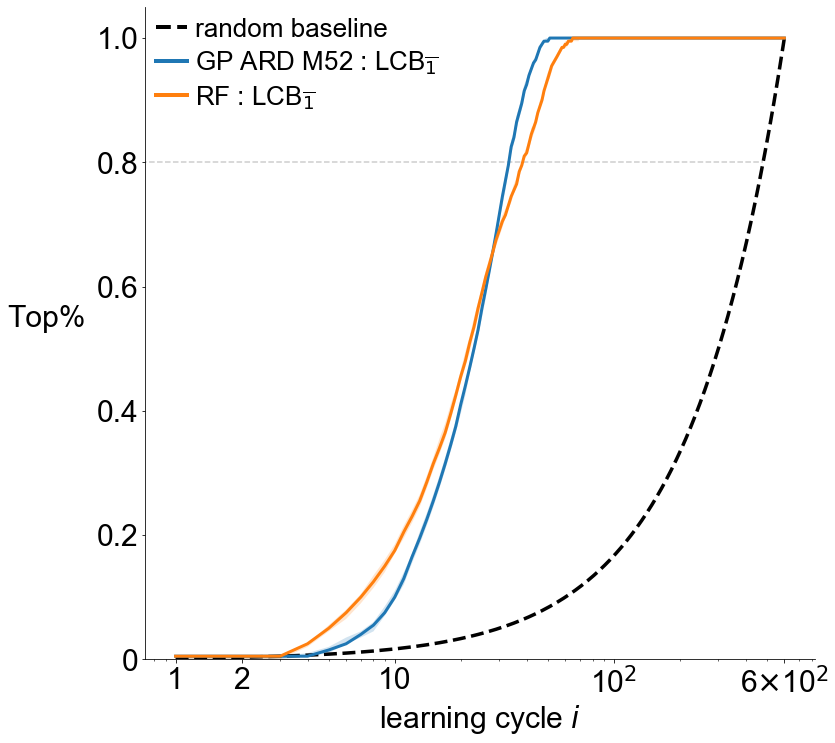

In [10]:
fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

ax0.plot(np.arange(nsteps)+1, P_rand(nsteps)[0],'--',color='black',label='random baseline', linewidth=3.5)

ax0.plot(np.arange(nsteps)+1, np.round(TopPercent_GP_ARD_Matern52_LCB1[0].astype(np.double) / 0.005, 0) * 0.005, label = 'GP ARD M52 : LCB$_{\overline{1}}$', linewidth=3)
ax0.fill_between(np.arange(nsteps)+1, np.round(TopPercent_GP_ARD_Matern52_LCB1[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TopPercent_GP_ARD_Matern52_LCB1[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

ax0.plot(np.arange(nsteps)+1, np.round(TopPercent_RF_LCB1[0].astype(np.double) / 0.005, 0) * 0.005, label = 'RF : LCB$_{\overline{1}}$', linewidth=3)
ax0.fill_between(np.arange(nsteps)+1, np.round(TopPercent_RF_LCB1[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TopPercent_RF_LCB1[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

# the rest are for visualization purposes, please adjust for different needs
font = font_manager.FontProperties(family='Arial', size = 26, style='normal')

leg = ax0.legend(prop = font, borderaxespad = 0,  labelspacing = 0.3, handlelength = 1.2, handletextpad = 0.3, frameon=False, loc = 'upper left')
for line in leg.get_lines():
    line.set_linewidth(4)
ax0.set_ylabel("Top%", fontname="Arial", fontsize=30, rotation='horizontal', labelpad = 50)    
plt.hlines(0.8, 0, 480, colors='k', linestyles='--', alpha = 0.2)


ax0.set_ylim([0, 1.05])
ax0.set_xscale('log')
ax0.set_xlabel('learning cycle $i$', fontsize=30, fontname = 'Arial')
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
plt.xticks([1, 2, 10, 100, 600], ['1', '2','10', '10$^{\mathrm{2}}$', '6$×$10$^{\mathrm{2}}$'],fontname = 'Arial')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontname = 'Arial')

# Enhancement Factor

In [11]:
def EF(x):
    n_eval = len(x)
    TopPercent_RS = P_rand(n_eval)[0]
    
    l_EF = []
    for j in np.arange(n_eval):
        l_EF.append(x[j] / TopPercent_RS[j])
        
    return l_EF

([<matplotlib.axis.YTick at 0x1a2c6a6f50>,
 <a list of 5 Text yticklabel objects>)

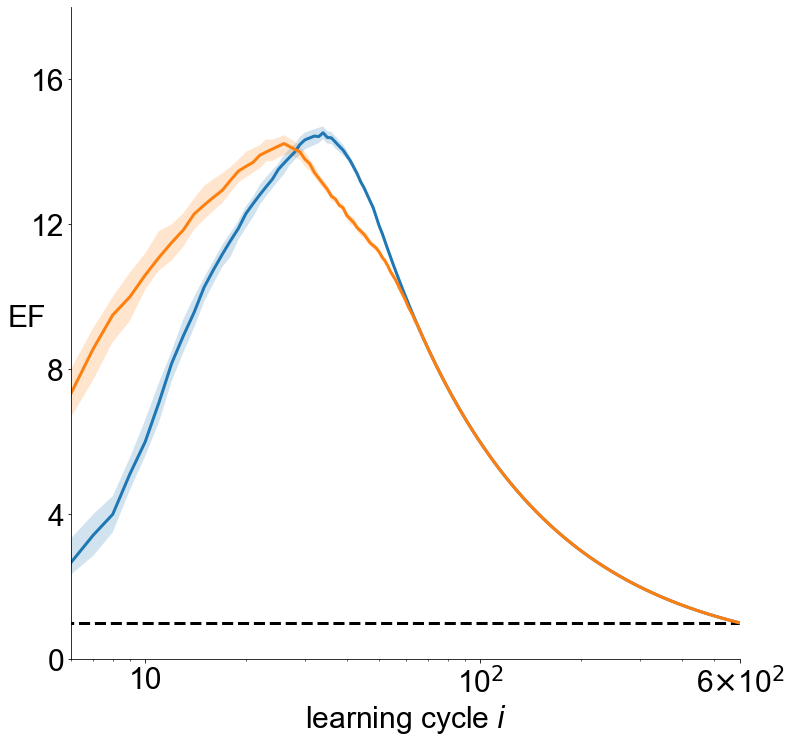

In [12]:
fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

ax0.plot(np.linspace(1, nsteps, nsteps), np.ones(nsteps),'--',color='black',label='random baseline', linewidth = 3)        

ax0.plot(np.arange(nsteps)+1, EF(TopPercent_GP_ARD_Matern52_LCB1[0]), label = 'GP ARD M52 : LCB$_{\overline{1}}$', linewidth=3)
ax0.fill_between(np.arange(nsteps)+1, EF(TopPercent_GP_ARD_Matern52_LCB1[1]), EF(TopPercent_GP_ARD_Matern52_LCB1[2]), alpha=0.2)

ax0.plot(np.arange(nsteps)+1, EF(TopPercent_RF_LCB1[0]), label = 'RF : LCB$_{\overline{1}}$', linewidth=3)
ax0.fill_between(np.arange(nsteps)+1, EF(TopPercent_RF_LCB1[1]), EF(TopPercent_RF_LCB1[2]), alpha=0.2)

# the rest are for visualization purposes, please adjust for different needs
ax0.set_ylabel('EF', fontsize=30, rotation = 'horizontal', fontname = 'Arial')
ax0.set_xlabel('learning cycle $i$', fontsize=30, fontname = 'Arial')
ax0.set_xlim([6, 600])
ax0.set_ylim([0, 18])
ax0.set_xscale('log')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
plt.xticks([10, 100, 600], ['10', '10$^{\mathsf{2}}$', '6$×$10$^{\mathsf{2}}$'],fontname = 'Arial')
plt.yticks([0, 4, 8, 12, 16], ['0', '4', '8', '12', '16'], fontname = 'Arial')

# Acceleration Factor

In [13]:
def AF(x):
    n_eval = len(x)
    TopPercent_RS = list(np.round(P_rand(n_eval)[0].astype(np.double) / 0.005, 0) * 0.005)
#     We check Top% at 0.005 intervals between 0 and 1.
    l_TopPercent = []
    l_AF = []
    
    x = list(np.round(x.astype(np.double) / 0.005, 0) * 0.005)
    
    TopPercent = np.arange(0, 1.005, 0.005)
    
    pointer_x = 0
    pointer_rs = 0
    for t in TopPercent:
        if t in x and t in TopPercent_RS:
            n_x = 0
            n_rs = 0
            while pointer_x < len(x):
                if x[pointer_x] == t:
                    pointer_x += 1
                    n_x = pointer_x
                    break
                else:
                    pointer_x += 1

            while pointer_rs < len(TopPercent_RS):
                if TopPercent_RS[pointer_rs] == t:
                    pointer_rs += 1
                    n_rs = pointer_rs
                    break
                else:
                    pointer_rs += 1
        
            l_TopPercent.append(t)
            
            AF = n_rs / n_x
            l_AF.append(AF)  
        
    return l_TopPercent, l_AF

# smoothing for visualization purposes
def AF_interp1d(TopPercent):
    f_med = interp1d(AF(TopPercent[0])[0], AF(TopPercent[0])[1], kind = 'linear', fill_value='extrapolate')
#     again 0.005 intervals
    xx_ = np.linspace(min(AF(TopPercent[0])[0]), 1, 201 - int(min(AF(TopPercent[0])[0])/0.005))
    f_low = interp1d(AF(TopPercent[1])[0], AF(TopPercent[1])[1], kind = 'linear', fill_value='extrapolate')
    f_high = interp1d(AF(TopPercent[2])[0], AF(TopPercent[2])[1], kind = 'linear', fill_value='extrapolate')   
    return xx_, f_med, f_low, f_high

([<matplotlib.axis.YTick at 0x1a2c6df190>,
 <a list of 5 Text yticklabel objects>)

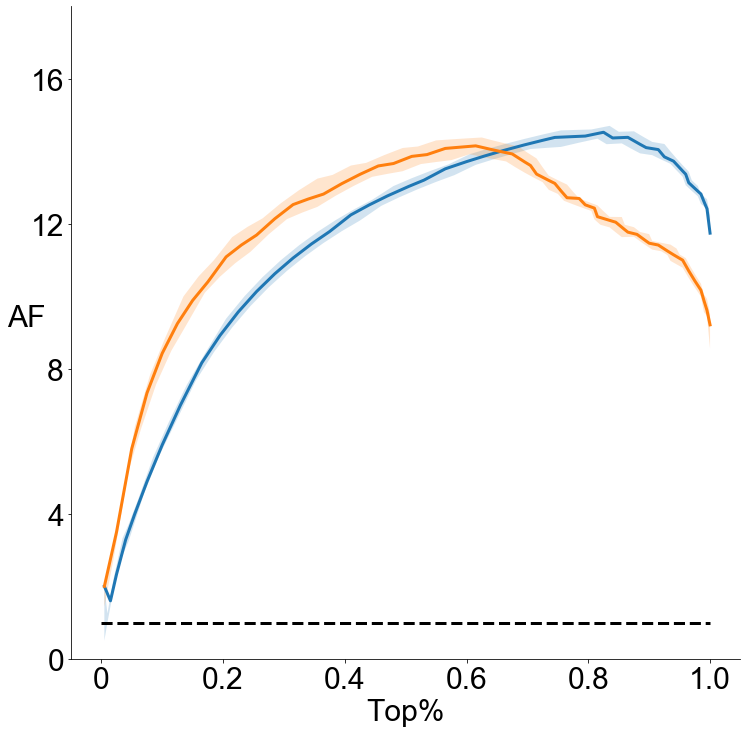

In [14]:
fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

ax0.plot(np.linspace(0, 1, 176), np.ones(176),'--',color='black',label=None, linewidth=3)  

xx_, f_med_, f_low_, f_high_ = AF_interp1d(TopPercent_GP_ARD_Matern52_LCB1)
ax0.plot(xx_, f_med_(xx_), label = 'GP ARD M52 : LCB$_{\overline{1}}$', linewidth=3)
ax0.fill_between(xx_, f_low_(xx_), f_high_(xx_), alpha=0.2)

xx_, f_med_, f_low_, f_high_ = AF_interp1d(TopPercent_RF_LCB1)
ax0.plot(xx_, f_med_(xx_), label = 'RF : EI', linewidth=3)
ax0.fill_between(xx_, f_low_(xx_), f_high_(xx_), alpha=0.2)

# the rest are for visualization purposes, please adjust for different needs
ax0.set_ylabel('AF', fontsize = 30, rotation = 'horizontal', fontname = 'Arial')
ax0.set_xlabel('Top%', fontsize = 30, fontname = 'Arial')
ax0.set_ylim([0, 18])
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontname = 'Arial')
plt.yticks([0, 4, 8, 12, 16], ['0', '4', '8', '12', '16'], fontname = 'Arial')